In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory

## required packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.tsa.stattools as sts_tools
import statsmodels as sm
import statsmodels.api
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from scipy.stats import norm

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
import json
from oandapyV20 import API
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
import pandas as pd


def get_data(granularity, instrument, save_csv=False):
    client = API(access_token="e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d")
    

    params = {

        "granularity": granularity,
        "count": 1500,
     }
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
            rv = client.request(r)
            results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                        "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                       "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                       } for candle in r.response.get('candles')]
            df = df.append(pd.DataFrame(results), ignore_index=True)

    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
df = get_data(instrument = "USD_CHF", granularity = "H1", save_csv = False)
df.tail()

Open     High      Low    Close  Volume
Date                                                           
2022-02-27T22:00:00  0.92752  0.92838  0.92475  0.92732  9897.0
2022-02-27T23:00:00  0.92752  0.92786  0.92526  0.92688  9456.0
2022-02-28T00:00:00  0.92688  0.92782  0.92539  0.92642  5913.0
2022-02-28T01:00:00  0.92639  0.92746  0.92625  0.92686  7037.0
2022-02-28T02:00:00  0.92685  0.92747  0.92664  0.92726  2573.0

In [5]:
df = df.reset_index()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1500 non-null   object 
 1   Open    1500 non-null   float64
 2   High    1500 non-null   float64
 3   Low     1500 non-null   float64
 4   Close   1500 non-null   float64
 5   Volume  1500 non-null   float64
dtypes: float64(5), object(1)
memory usage: 70.4+ KB


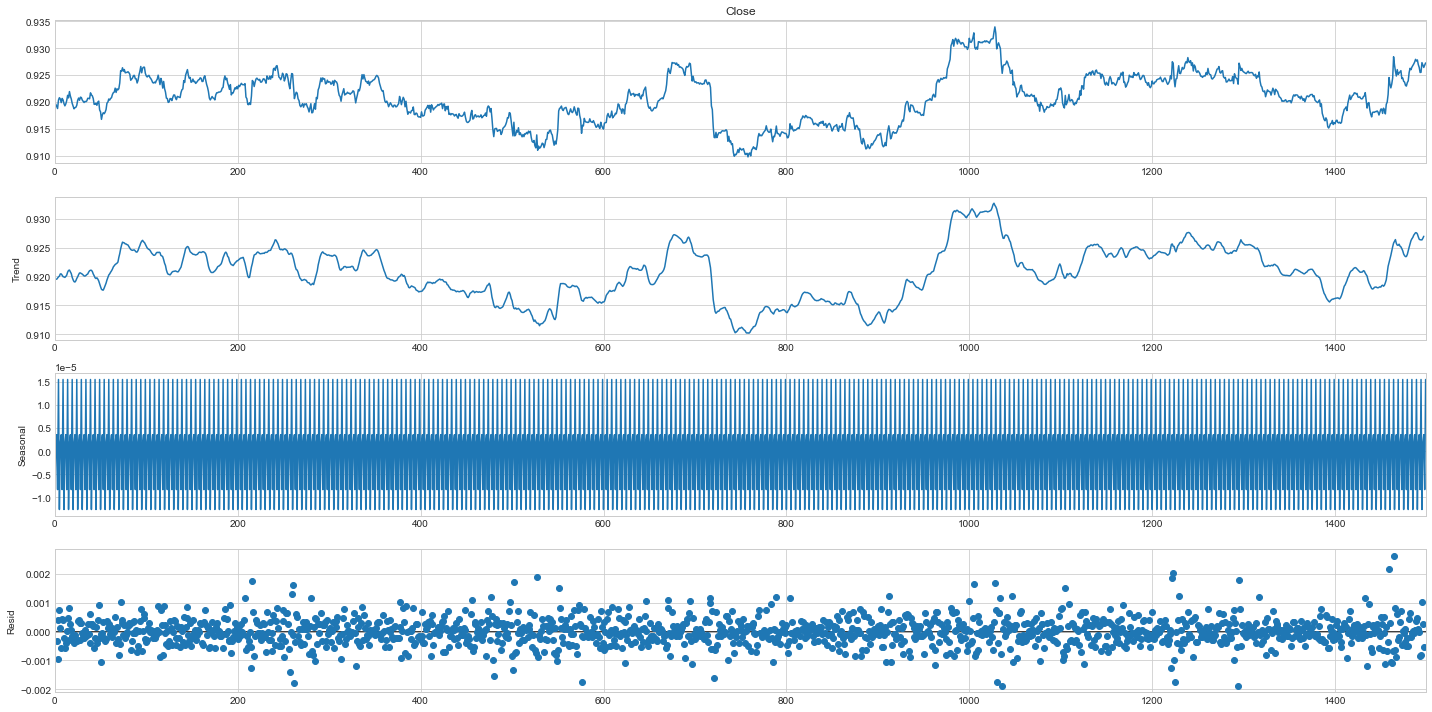

In [7]:
plt.rcParams['figure.figsize'] = 20, 10

res = sm.tsa.seasonal.seasonal_decompose(df['Close'], model='additive', freq=5) ## weekly seasonality
res.plot()
plt.show()

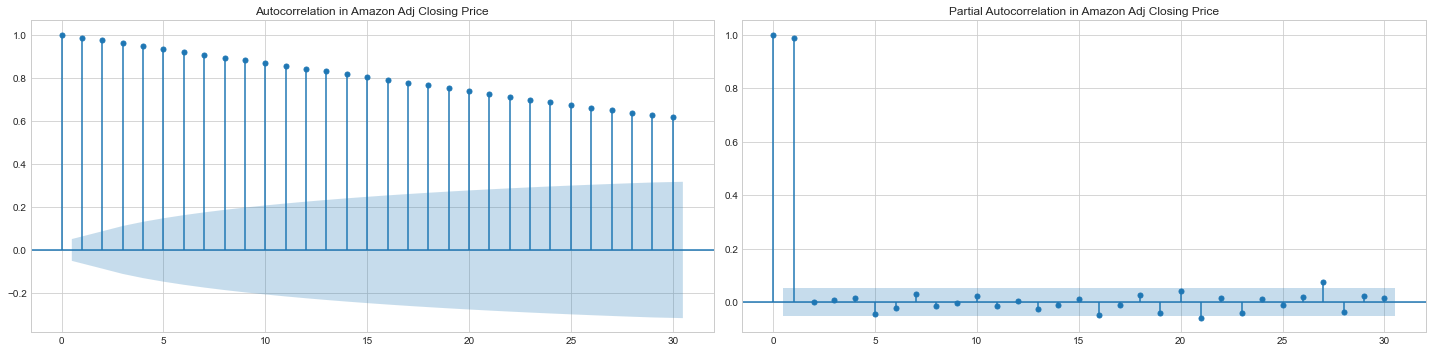

In [8]:
max_lags = 30
fig, axes = plt.subplots(1, 2, figsize=(20,5))

plot_acf(df['Close'], alpha=0.05, lags=max_lags, ax = fig.axes[0], title = 'Autocorrelation in Amazon Adj Closing Price')
plot_pacf(df['Close'], alpha=0.05, lags=max_lags, ax = fig.axes[1], title = 'Partial Autocorrelation in Amazon Adj Closing Price')

fig.tight_layout()

In [9]:
SEED = 684

## Build structural time series model
## Includes components for local linear trend, weekly seasonality and autoregressive model
def build_model(observed_time_series, lags, observation_noise_scale_prior):
    linear_trend = tfp.sts.SemiLocalLinearTrend(
        observed_time_series = observed_time_series
    )

        
    hour_of_day_effect = tfp.sts.Seasonal(
      num_seasons=24,
      observed_time_series=observed_time_series,
      name='hour_of_day_effect')
    
    dayofweek_season = tfp.sts.Seasonal(
        num_seasons = 5,
        num_steps_per_season = 24,
        observed_time_series = observed_time_series, 
        constrain_mean_effect_to_zero = False,
        name = "dayofweek_season"
    )

    autoregressive = tfp.sts.Autoregressive(
        order = lags,
        observed_time_series = observed_time_series
    )

    model = tfp.sts.Sum(
        [dayofweek_season, linear_trend, autoregressive], 
        observed_time_series = observed_time_series,
        observation_noise_scale_prior = observation_noise_scale_prior
    )
    return model

## To fit the model to data, we define a surrogate posterior and 
## fit it by minimizing the negative variational evidence lower bound (ELBO)
def fit_variational_posterior(model, variational_posteriors, observed_time_series):
    elbo_loss = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn = model.joint_log_prob(observed_time_series = observed_time_series),
        surrogate_posterior = variational_posteriors,
        optimizer = tf.optimizers.Adam(learning_rate = 0.1),
        num_steps = 60,
        seed = SEED
    )
    return elbo_loss

## Plot ELBO curve
def plot_elbo_loss(elbo_loss):
    fig = go.Figure(data=go.Scatter(x = np.arange(len(elbo_loss)), y = elbo_loss))
    fig.update_layout(title_text='ELBO Plot')
    fig.update_xaxes(title_text='Number of Iterations')
    fig.update_yaxes(title_text='-ve ELBO')
    fig.show()
    
## Forecast for `num_forecast_steps` days
def forecast(model, samples, observed_time_series, num_forecast_steps):
    forecast_dist = tfp.sts.forecast(
        model, 
        observed_time_series = observed_time_series, 
        parameter_samples = samples,
        num_steps_forecast = num_forecast_steps
    )
    forecast_mean = forecast_dist.mean().numpy().flatten()
    forecast_std = forecast_dist.stddev().numpy().flatten()
    return {'mean': forecast_mean, 'scale': forecast_std}

## Forecast the next 20 days using one-step-prediction which will give 
## predictive distribution over observations at each time T, given observations up through time T-1.
def forecast_onestep_prediction(model, samples, observed_time_series, num_forecast_steps):
    forecast_dist = tfp.sts.one_step_predictive(
        model, 
        observed_time_series = observed_time_series, 
        parameter_samples = samples
    )
    forecast_mean = forecast_dist.mean().numpy()[-num_forecast_steps:]
    forecast_std = forecast_dist.stddev().numpy()[-num_forecast_steps:]
    return {'mean': forecast_mean, 'scale': forecast_std}


## Extract inferred value of model Parameters
def extract_model_params(model, samples):
    model_params = {}
    for param in model.parameters:
        model_params[param.name] = {
            "point_estimate": np.mean(samples[param.name], axis=0),
            "uncertainity": np.std(samples[param.name], axis=0)
        }
    return pd.DataFrame.from_dict(model_params).T

In [10]:
## Number of days to be forecasted
num_forecast_steps = 10

## Extract training data
market_data = df[['High']]
market_train_data = market_data
market_train_data_len = len(market_train_data)

## Extract noise scale prior for observation noise from the closing price using daily returns
# noise_scale = market['Daily Returns'].std()
# noise_scale_prior = tfp.distributions.Normal(np.float64(0.0), np.float64(1.0))

In [11]:
## Build Model
model_lag1 = build_model(market_train_data, 1, None)

## Build variational surrogate posterior
variational_posteriors_lag1 = tfp.sts.build_factored_surrogate_posterior(model = model_lag1, seed = SEED)

## To fit the model to data, we define a surrogate posterior and 
## fit it by minimizing the negative variational evidence lower bound (ELBO)
elbo_loss_lag1 = fit_variational_posterior(model_lag1, variational_posteriors_lag1, market_train_data)

## Plot ELBO
plot_elbo_loss(elbo_loss_lag1)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


In [12]:
## Draw samples from posterior
samples_lag1 = variational_posteriors_lag1.sample(20)

In [13]:
model_params = extract_model_params(model_lag1, samples_lag1)
model_params

point_estimate  \
observation_noise_scale                                 0.00006   
dayofweek_season/_drift_scale                          0.000281   
SemiLocalLinearTrend/_level_scale                      0.000591   
SemiLocalLinearTrend/_slope_mean                      -0.000082   
SemiLocalLinearTrend/_slope_scale                      0.000287   
SemiLocalLinearTrend/_autoregressive_coef              0.584126   
Autoregressive/_coefficients               [0.5733924254404901]   
Autoregressive/_level_scale                            0.000134   

                                                   uncertainity  
observation_noise_scale                                 0.00001  
dayofweek_season/_drift_scale                          0.000319  
SemiLocalLinearTrend/_level_scale                      0.000015  
SemiLocalLinearTrend/_slope_mean                       0.000014  
SemiLocalLinearTrend/_slope_scale                      0.000112  
SemiLocalLinearTrend/_autoregressive_coef              0.100111  
Autoregressive/_coefficients               [0.4102380375436644]  
Autoregressive/_level_scale                            0.000109

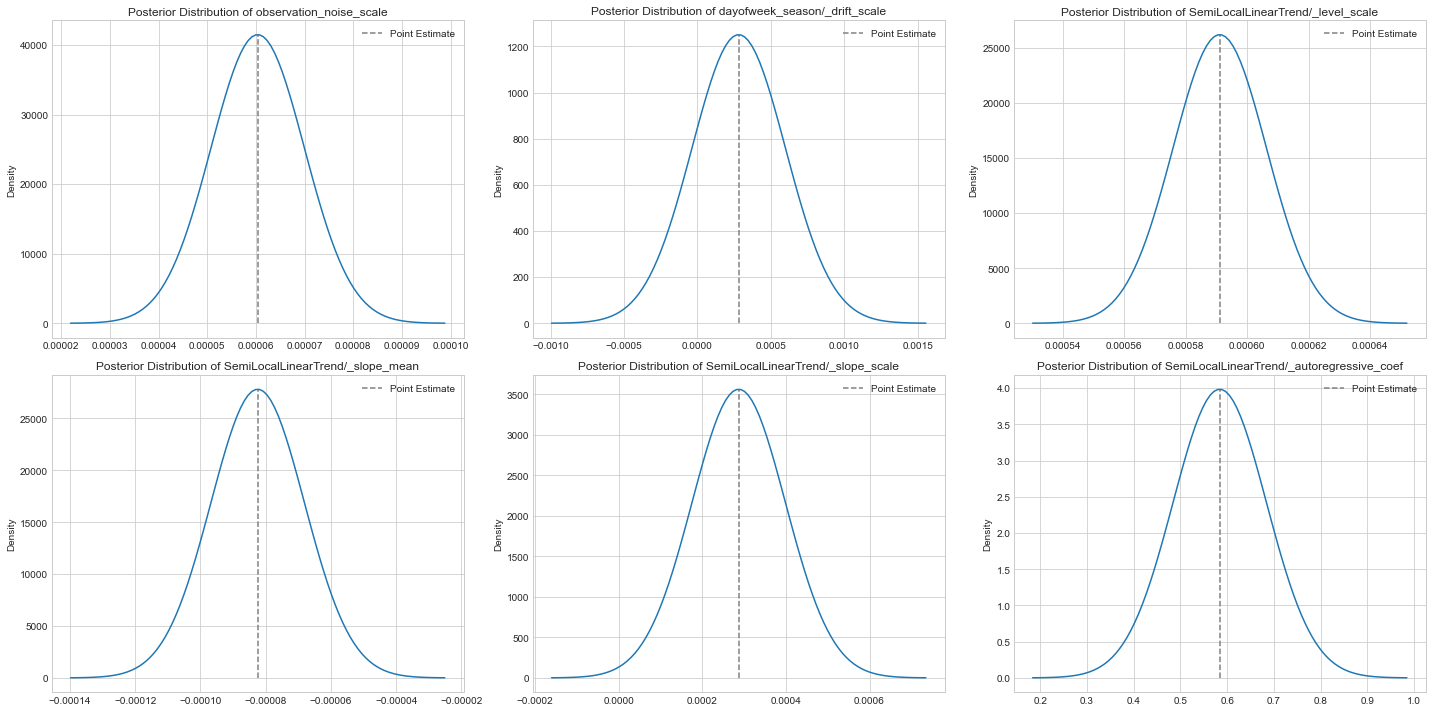

In [14]:
fig, axes = plt.subplots(2, 3)
for param, loc, scale, ax in zip(model_params.index, model_params['point_estimate'], model_params['uncertainity'], fig.axes):
    x = np.linspace(loc - 4*scale, loc + 4*scale, 100)
    y = norm.pdf(x, loc, scale)
    ax.plot(x, y)
    ax.vlines(loc, 0, max(y), linestyles = 'dashed', color = 'grey', label='Point Estimate')
    ax.set_title('Posterior Distribution of {}'.format(param))
    ax.set_ylabel('Density')
    ax.legend()
fig.tight_layout()

In [15]:
## Forecast next 20 days
forecast_params_lag1 = forecast(model_lag1, samples_lag1, market_train_data, num_forecast_steps)

In [16]:
print(forecast_params_lag1)

{'mean': array([0.92738726, 0.92730584, 0.92722374, 0.92714152, 0.92705913,
       0.92697667, 0.92689416, 0.92681161, 0.92672904, 0.92664647]), 'scale': array([0.00072505, 0.0010987 , 0.00141951, 0.00170629, 0.00196715,
       0.00220686, 0.0024289 , 0.002636  , 0.00283033, 0.00301366])}


In [17]:

df = pd.DataFrame(forecast_params_lag1['mean'])

<AxesSubplot:>

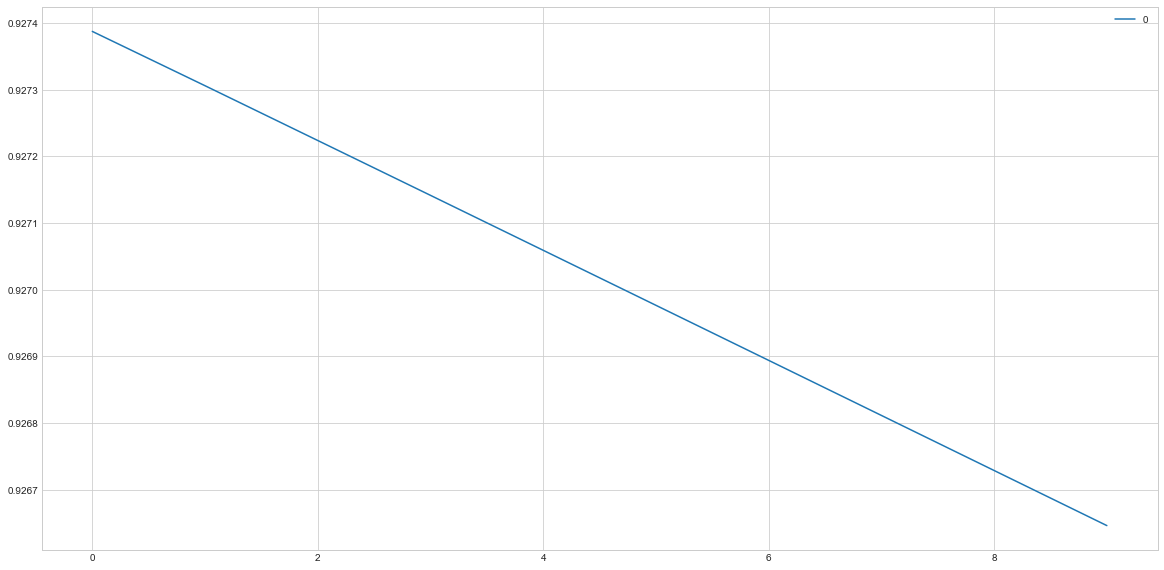

In [18]:
df.plot()

In [19]:
df1 = pd.DataFrame(forecast_params_lag1['scale'])

<AxesSubplot:>

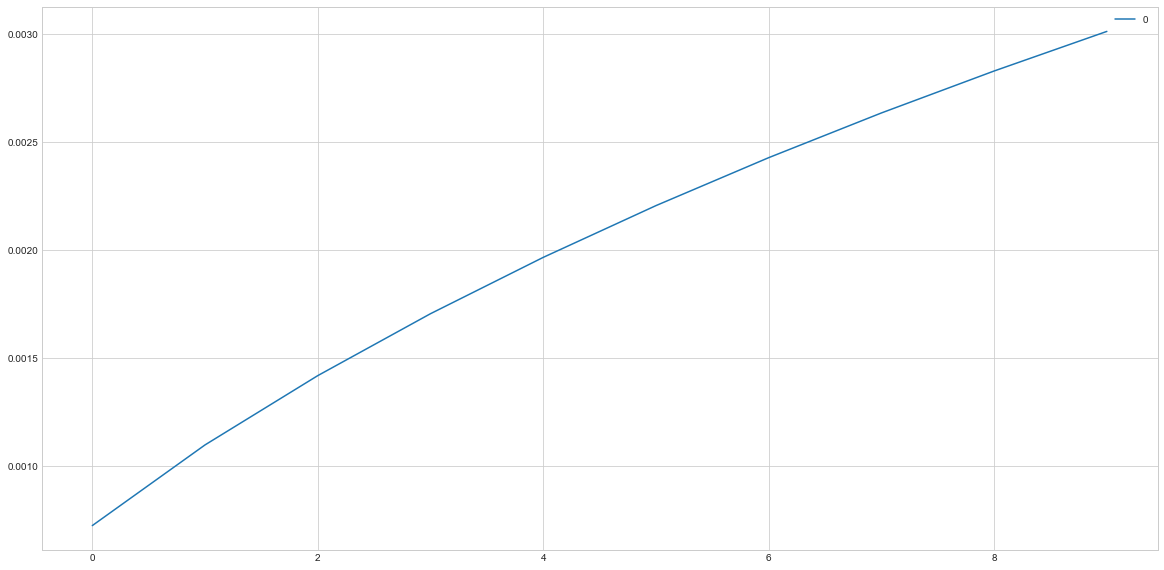

In [20]:
df1.plot()